### Let's start by importing the libraries, packages and helper classes we need for this course !

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from Models.CustomClassifier import DecisionTree
from Utilities.Evaluate import evaluate
import Utilities.Visualization as vs

### Now let's load the provided datasets

In [3]:
clean_filepath = "Data/wifi_db/clean_dataset.txt"
noisy_filepath = "Data/wifi_db/noisy_dataset.txt"

clean_dataset, noisy_dataset = np.loadtxt(clean_filepath, dtype = np.float32), np.loadtxt(noisy_filepath, dtype = np.float64)

### Lets verify if the data is properly loaded and display their shapes!

In [4]:
print("Shape of Clean Dataset : ", clean_dataset.shape)
print("Shape of Noisy Dataset : ", noisy_dataset.shape)

Shape of Clean Dataset :  (2000, 8)
Shape of Noisy Dataset :  (2000, 8)


### Now that we have loaded our datasets, let's try to get some metrics to compare them. We will be utilizing the mean, standard-deviation, Z-scores and Signal-To-Noise (SNR) ratio to compare our datasets

In [8]:
def avg_z_score(dataset):
        X = dataset[:, : -1]
        mean = np.mean(X)
        std_dev = np.std(X)
        
        z_score = (X - mean)/std_dev
        
        return np.mean(np.abs(z_score))
    
print("Mean and SD of clean data : ", np.mean(clean_dataset[:, : -1]), np.std(clean_dataset[:, : -1]))
print("Mean and SD of noisy data : ", np.mean(noisy_dataset[:,: -1]), np.std(noisy_dataset[:,: -1]))
    
    
print(f"Z-score of Clean Data : {avg_z_score(clean_dataset): .7f}")
print(f"Z-score of Noisy Data : {avg_z_score(noisy_dataset): .7f}")

def signal_to_noise_ratio(dataset):
    X = dataset[:, :-1]
        
    mean_signal = np.mean(X)
    std_noise = np.std(X)
        
        
    snr = mean_signal / std_noise if std_noise > 0 else 0
        
    avg_snr = np.mean(snr)
    return avg_snr

snr_clean_dataset = signal_to_noise_ratio(clean_dataset)
snr_noisy_dataset = signal_to_noise_ratio(noisy_dataset)

print(f"Average Signal-to-Noise Ratio for Clean Dataset: {snr_clean_dataset:.4f}")
print(f"Average Signal-to-Noise Ratio for Noisy Dataset: {snr_noisy_dataset:.4f}")



Mean and SD of clean data :  -63.1195 14.458628
Mean and SD of noisy data :  -63.1195 14.458628359416196
Z-score of Clean Data :  0.8129022
Z-score of Noisy Data :  0.8129022
Average Signal-to-Noise Ratio for Clean Dataset: -4.3655
Average Signal-to-Noise Ratio for Noisy Dataset: -4.3655


### Surprisingly, the metrics quite similar !

### Visualizing The Decision Tree
#### Let's take a detour and try to visualize what our Decision Tree would look like, when trained on the entire 'clean_dataset'

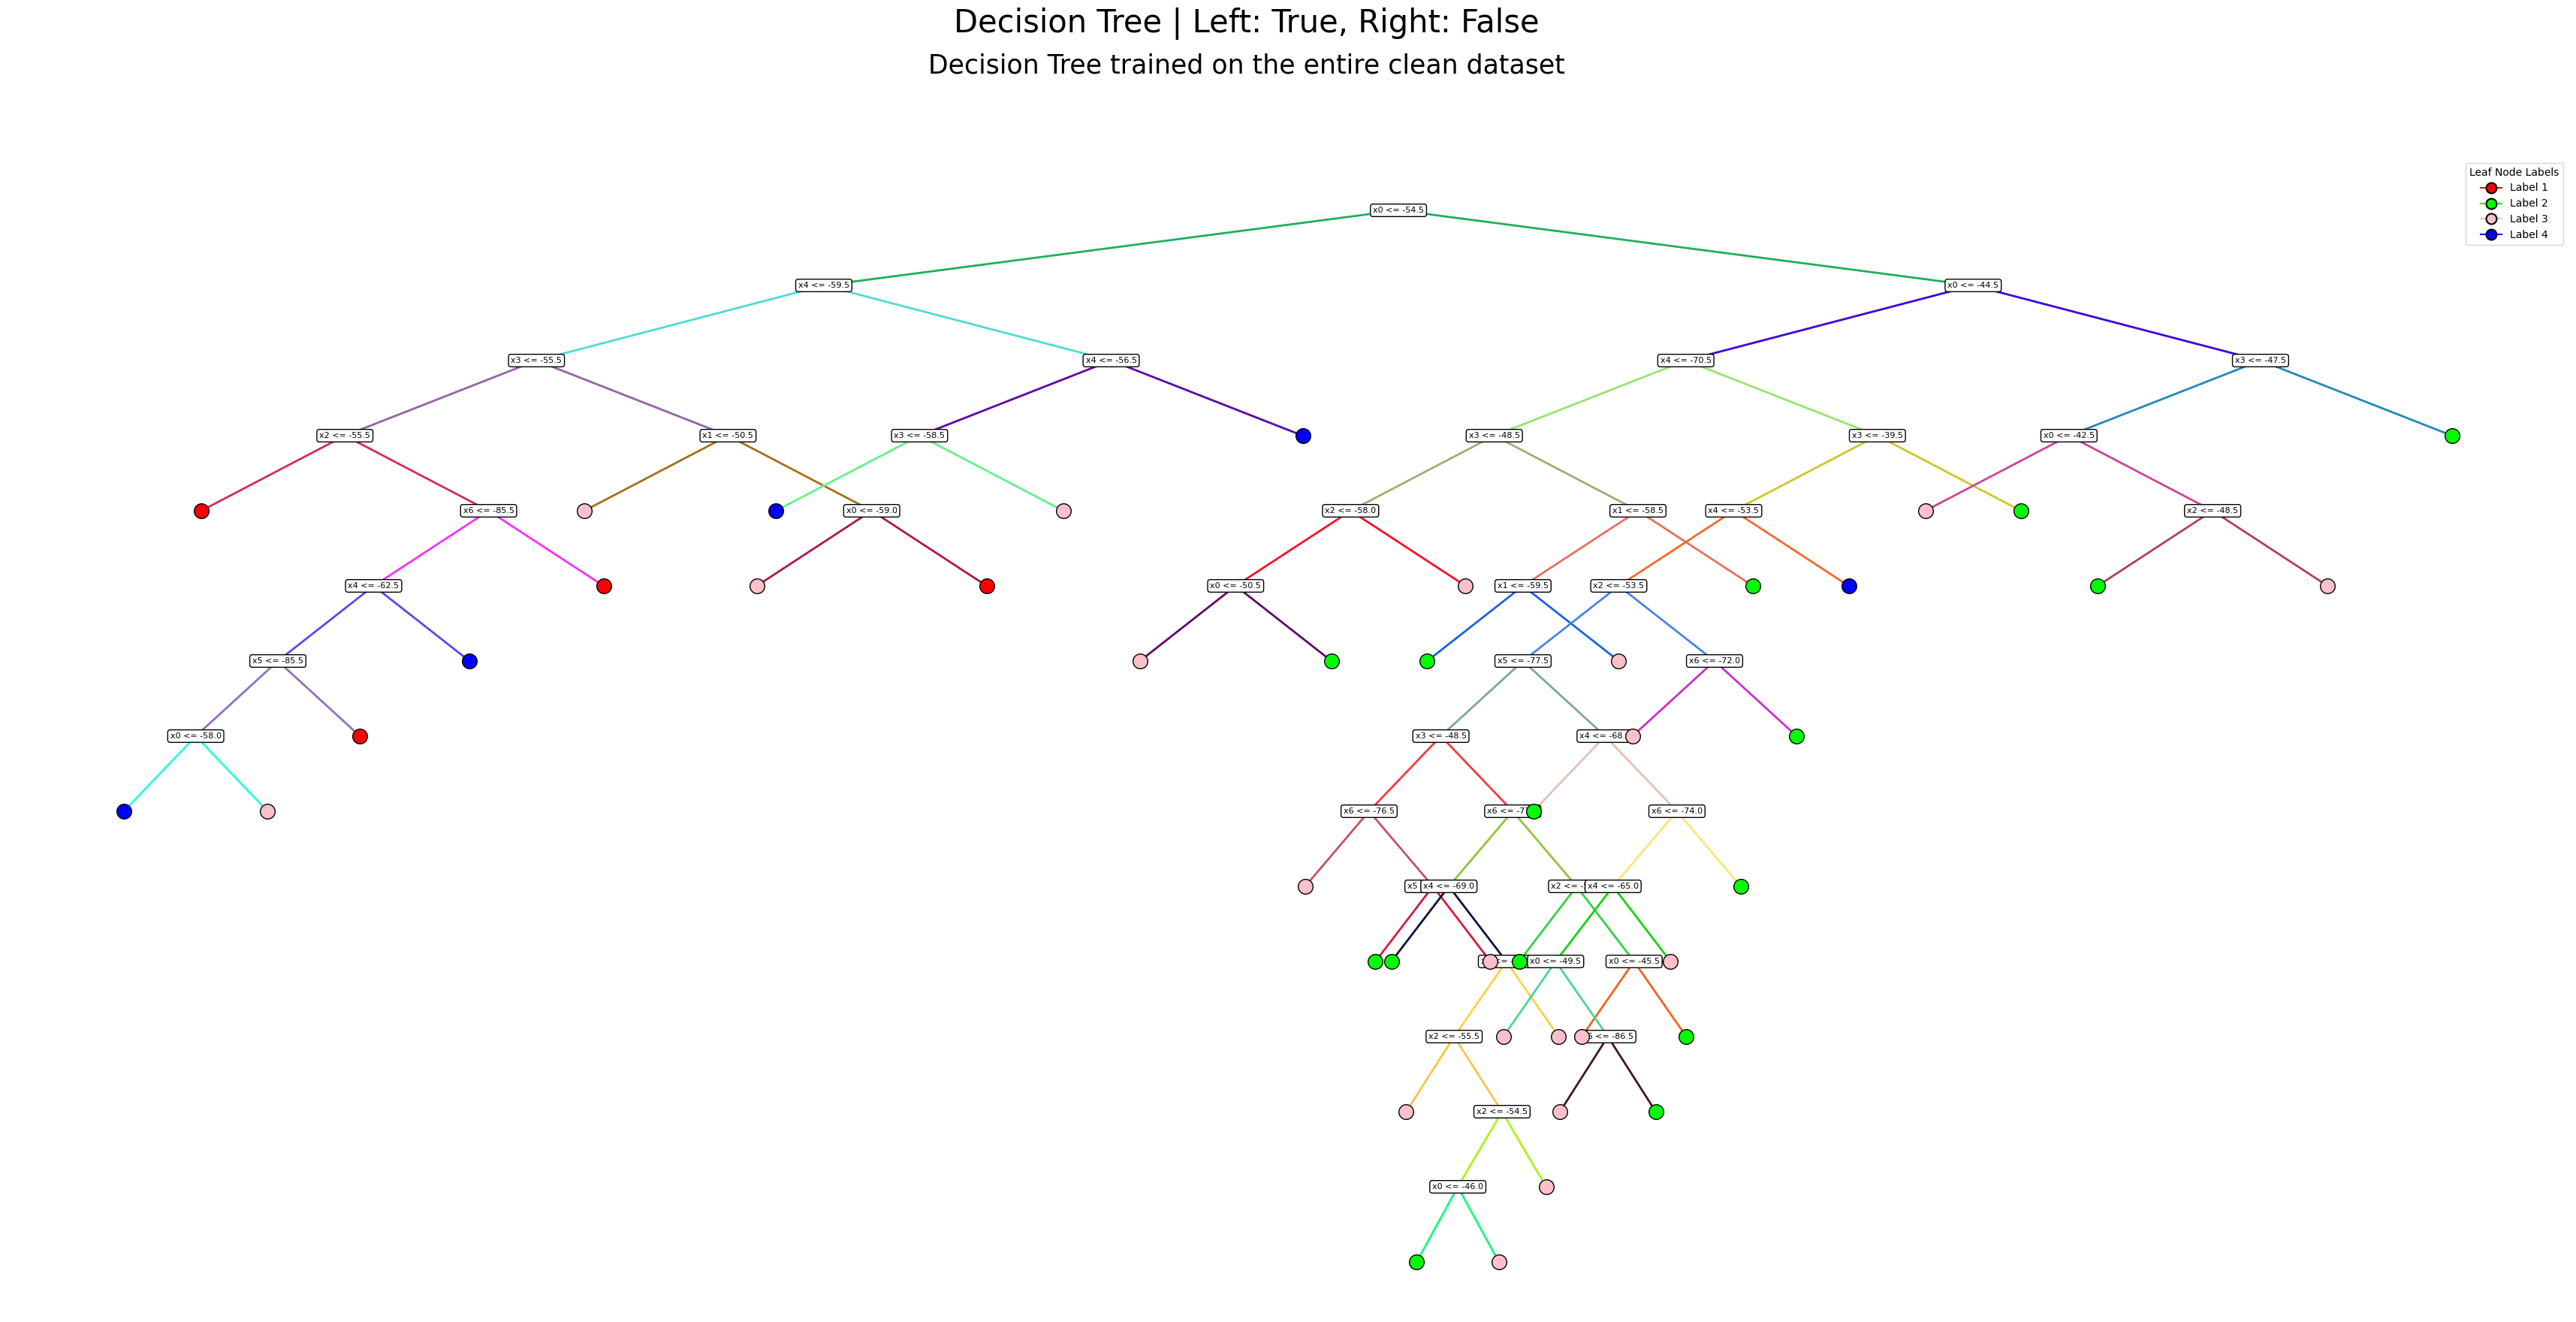

Tree visualization saved as: tree_visualizations\decision_tree_clean_dataset.png


<Figure size 640x480 with 0 Axes>

In [4]:
clf = DecisionTree()
root, _ = clf.fit(clean_dataset)
vs.save_tree_as_png(root, folder="tree_visualizations", filename="decision_tree_clean_dataset.png", subtext=f"Decision Tree trained on the entire clean dataset")

In [6]:
decision_tree = DecisionTree()

### We are defining the logic for k-fold validation here, which we are going to use shortly (without pruning)

In [10]:
def k_fold_cross_validation(dataset, n_splits, n_classes):
    
    np.random.shuffle(dataset)
    n_samples = len(dataset)
    fold_size = n_samples // n_splits
    indices = np.arange(n_samples)

    # Variables to accumulate results
    total_cm = np.zeros((n_classes, n_classes), dtype=int)  # Adjust for number of classes if needed
    total_accuracy = 0
    total_precision = np.zeros(4)  # Adjust for number of classes
    total_recall = np.zeros(4)     # Adjust for number of classes
    total_f1 = np.zeros(4)         # Adjust for number of classes

    for i in range(n_splits):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]], axis = 0)

        # Prepare training and testing data
        train_set = dataset[train_indices]
        test_set = dataset[test_indices]

        # Train the decision tree
        decision_tree.fit(train_set)
        # Evaluate performance on the test fold
        cm, precision, recall, accuracy, f1 = evaluate(test_set, decision_tree, 4)

        # Accumulate results
        total_cm += cm
        total_accuracy += accuracy
        total_precision += precision
        total_recall += recall
        total_f1 += f1

    # Compute averages    
    average_cm = total_cm // n_splits
    average_accuracy = total_accuracy / n_splits
    average_precision = total_precision / n_splits
    average_recall = total_recall / n_splits
    average_f1 = total_f1 / n_splits
    
    return total_cm, average_cm, average_accuracy, average_precision, average_recall, average_f1

### Its time to implement a 10-fold validation on "Clean Dataset" that we have (without pruning)

In [12]:
total_cm, average_cm, average_accuracy, average_precision, average_recall, average_f1 = k_fold_cross_validation(clean_dataset, 10, 4)

print("Total Confusion Matrix:\n", total_cm)

print("Average Confusion Matrix per fold :\n", average_cm)
print("Average Accuracy:", average_accuracy)
print("Average Precision per Class:", average_precision)
print("Average Recall per Class:", average_recall)
print("Average F1 Score per Class:", average_f1)

Total Confusion Matrix:
 [[495   0   2   3]
 [  0 480  20   0]
 [  3  19 476   2]
 [  5   0   2 493]]
Average Confusion Matrix per fold :
 [[49  0  0  0]
 [ 0 48  2  0]
 [ 0  1 47  0]
 [ 0  0  0 49]]
Average Accuracy: 0.9719999999999999
Average Precision per Class: [0.98446346 0.96127842 0.95261832 0.98957333]
Average Recall per Class: [0.99038996 0.96317433 0.95169817 0.98554492]
Average F1 Score per Class: [0.98726093 0.961697   0.95137782 0.98741574]


### Running 10 fold validation on "Noisy Dataset" (without pruning)

In [13]:
total_cm_noisy, average_cm_noisy, average_accuracy_noisy, average_precision_noisy, average_recall_noisy, average_f1_noisy = k_fold_cross_validation(noisy_dataset, 10, 4)

print("Total Confusion Matrix for the Noisy Dataset:\n", total_cm_noisy)
print("Average Confusion Matrix For Noisy Dataset per fold:\n", average_cm_noisy)
print("Average Accuracy for Noisy Dataset:", average_accuracy_noisy)
print("Average Precision per Class for Noisy Dataset:", average_precision_noisy)
print("Average Recall per Class for Noisy Dataset:", average_recall_noisy)
print("Average F1 Score per Class for Noisy Dataset:", average_f1_noisy)


Total Confusion Matrix for the Noisy Dataset:
 [[388  34  28  40]
 [ 25 396  45  31]
 [ 29  43 405  38]
 [ 46  23  36 393]]
Average Confusion Matrix For Noisy Dataset per fold:
 [[38  3  2  4]
 [ 2 39  4  3]
 [ 2  4 40  3]
 [ 4  2  3 39]]
Average Accuracy for Noisy Dataset: 0.791
Average Precision per Class for Noisy Dataset: [0.79495884 0.80140493 0.78730721 0.77889009]
Average Recall per Class for Noisy Dataset: [0.79366641 0.7982045  0.78562842 0.78594699]
Average F1 Score per Class for Noisy Dataset: [0.79199847 0.79780171 0.78444441 0.78117297]


### Now we will try to implement a more complex version of Cross-Validation, the _Nested_ k-fold cross validation ("Option 2")! The idea behind a nested cross validation is to further utilize the training set across every fold, and do a k-fold validation in the same. Finally, we can test our model against the test set that we have in each outer fold.  This provides for a space for _grid-search_ for _hyperparameters_ tuning (if we have), and choose and optimal value across the various folds. Since we do no have any hyperparameter here, we will just utilize the inner folds for _Pruning_ of our trees across the validations and evaluate the average across all the models trained acrossed all folds. Let's see how it goes!

In [16]:
def nested_k_fold_cross_validation_with_pruning(dataset, n_classes,k=10,shuffle=True, random_state=2024):
    if shuffle:
        np.random.seed(random_state)
        indices = np.random.permutation(len(dataset))
    else:
        indices = np.arange(len(dataset))
        
    fold_sizes = len(dataset) // k
    folds = [indices[i * fold_sizes : (i + 1) * fold_sizes] for i in range(k)]
        
    total_val_accuracy_before_pruning, total_val_accuracy_after_pruning = 0, 0
        
    total_cm_pruned = np.zeros((n_classes, n_classes), dtype=int)  
    total_accuracy_pruned = 0
    total_precision_pruned = np.zeros(4)  
    total_recall_pruned = np.zeros(4)     
    total_f1_pruned = np.zeros(4)
        
    total_depth_before_pruning, total_depth_after_pruning = 0, 0
        
        
    for i in range(k):
        test_indices = folds[i]
        train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
            
        train_set, test_set = dataset[train_indices], dataset[test_indices]
            
        # Now we will use the train_set to perform inner k-folds cross validation
        # with kth set as validation set and rest (k-1) as training set
            
        inner_fold_sizes = len(train_set) // k
        inner_folds = [np.arange(len(train_set))[j * inner_fold_sizes : (j + 1) * inner_fold_sizes] for j in range(k)]
            
        for j in range(k):
            val_indices = inner_folds[j]
            inner_train_indices = np.concatenate([inner_folds[l] for l in range(k) if l != j])
                
            inner_train_set, val_set = train_set[inner_train_indices], train_set[val_indices]
                
            model = None # Just to initialize the model at the begining of every iteration so that it doesn't point to any previous structure
                
                
            model = DecisionTree()
                
            root_node, depth = model.fit(inner_train_set) 
                
            total_depth_before_pruning += depth 
                
                # We are checking the accuracy of the model in the validation set because we are going to prune 
                # Based on this very Validation Set, so keeping a track of performance now
            total_val_accuracy_before_pruning += model.accuracy(val_set) 
                
                                               
            model.prune(root_node, val_set)
                
                
            total_depth_after_pruning += model.find_depth(root_node)
            total_val_accuracy_after_pruning += model.accuracy(val_set) #Lets store to see if the accuracy increases over validation sets after pruning
                
            cm_pruned, precision_pruned, recall_pruned, accuracy_pruned, f1_pruned = evaluate(test_set, model, 4)
                
                
            total_cm_pruned += cm_pruned
            total_accuracy_pruned += accuracy_pruned
            total_precision_pruned += precision_pruned
            total_recall_pruned += recall_pruned
            total_f1_pruned += f1_pruned
                
                
                
    avg_cm = total_cm_pruned // (k*k)
    avg_accuracy = total_accuracy_pruned / (k*k)
    avg_precision = total_precision_pruned / (k*k)
    avg_recall = total_recall_pruned / (k*k)
    avg_f1 = total_f1_pruned / (k*k)
    avg_depth_before_pruning = total_depth_before_pruning  // (k*k)
    avg_depth_after_pruning = total_depth_after_pruning  // (k*k)
        
    avg_val_accuracy_before_pruning = total_val_accuracy_before_pruning / (k*k)
    avg_val_accuracy_after_pruning = total_val_accuracy_after_pruning / (k*k)
        
        
        
    print("Average Accuracy Across Validation Sets Before pruning : ", avg_val_accuracy_before_pruning )
    print("Average Accuracy Across Validation Sets After pruning: ", avg_val_accuracy_after_pruning )
        
        
    print("Average Confusion Matrix per fold :\n", avg_cm )
    print("Average Overall Accuracy Across Test Folds: ", avg_accuracy )
    print("Average Precision After Pruning : ", avg_precision )
    print("Average Recall After Pruning: ", avg_recall )
    print("Average f1 After Pruning: ", avg_f1 )
    print("Avg depth before pruning : ", avg_depth_before_pruning )
    print("Avg Depth after pruning : ", avg_depth_after_pruning )

### Running _nested_ 10 fold cross validation on "Clean Dataset" _with_ Pruning

In [15]:
nested_k_fold_cross_validation_with_pruning(clean_dataset, 4)

Average Accuracy Across Validation Sets Before pruning :  0.9714999999999998
Average Accuracy Across Validation Sets After pruning:  0.9765
Average Confusion Matrix per fold :
  [[49  0  0  0]
 [ 0 47  2  0]
 [ 1  2 45  0]
 [ 0  0  0 49]]
Average Overall Accuracy Across Test Folds:  0.9556500000000001
Average Precision After Pruning :  [0.96476917 0.94913361 0.94891816 0.96853733]
Average Recall After Pruning:  [0.98192117 0.9434366  0.91699758 0.98256218]
Average f1 After Pruning:  [0.97222013 0.94426528 0.93038837 0.9746918 ]
Avg depth before pruning :  12
Avg Depth after pruning :  9


### Running _nested_ 10-fold cross validation on "Noisy Dataset" _with_ Pruning

In [17]:
nested_k_fold_cross_validation_with_pruning(noisy_dataset, 4)

Average Accuracy Across Validation Sets Before pruning :  0.7978888888888892
Average Accuracy Across Validation Sets After pruning:  0.8366666666666664
Average Confusion Matrix per fold :
 [[36  5  3  3]
 [ 6 36  4  2]
 [ 5  5 36  3]
 [ 6  4  3 34]]
Average Overall Accuracy Across Test Folds:  0.72545
Average Precision After Pruning :  [0.73419716 0.77480012 0.81939871 0.82661292]
Average Recall After Pruning:  [0.7449112  0.74439093 0.71667088 0.70407565]
Average f1 After Pruning:  [0.70399359 0.72880921 0.74406776 0.74241642]
Avg depth before pruning :  18
Avg Depth after pruning :  16


### And we did it ! We implemented pruning of the decision tree and utilized  nested 10-fold cross validation to get the average metrics of our model. The average overall ccuracy of the model is lower in the noisy data than in the clean one (as one would expect). Also, for the _clean_ data, a tree with less depth was succesful in getting the desired accuracy, compared to the _noisy_ data. In both the scenarios, pruning helped to reduce the depth of the tree, performed better on the validation sets and improved the overall generalization of the trees, which otherwise was "Overfitting", i.e., having high variance towards the data.